## Introduction

This notebook analyzes the graph created by "pydgraph" script. The "pydgraph" script crawls all the packages installed in the current python deployment and then creates a newtork out of the dependencies. Every node is a package name and every edge indicates the dependency. This is directed graph.
Using this graph, we try to answer below questions
1. What is the degree distribution? What does it indicate? Is this scale free graph?
2. Does this network follow Friendship Paradox? How to use it?
3. How to identify communities? How to identify packages which are used by multiple communities?
4. The change propogation

In [103]:
import networkx as nx
import numpy as np
import matplotlib as plt
import os
import collections
import copy

In [104]:
cwd = os.getcwd()
data_folder = cwd + "/../pydgraph/resources/"
graph_file_name = data_folder + "pydgraph.gml"
graph_out_file_name = data_folder + "pydgraph_updated.gexf"

In [105]:
G = nx.read_gml(graph_file_name)
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 197
Number of edges: 490
Average in degree:   2.4873
Average out degree:   2.4873


## Indirect Dependency
When a module M1 imports another module M2, M1 automatically imports all the parents of M2. If we include such relationship directly in M1, we might get a completely different picture of the graph. 

Create such graph and analyze its degree distribution. Does it follow power law? 

In [106]:
def add_predecessors(graph, orgnode, currnode, dict_predecessors):
    for pnode in graph.predecessors(currnode):
        if pnode != node and pnode not in dict_predecessors[orgnode]:
            dict_predecessors[orgnode].append(pnode)
            add_predecessors(graph, orgnode, currnode, dict_predecessors)
            

#GNew = G.copy()
GNew = copy.deepcopy(G)
dict_predecessors = dict()
for node in GNew.nodes():
    dict_predecessors[node] = list()
    for pnode in GNew.predecessors(node):
        if pnode != node and pnode not in dict_predecessors[node]:
            #dict_predecessors[node].append(pnode)
            add_predecessors(GNew, node, pnode, dict_predecessors)

for node in dict_predecessors:
    for child in dict_predecessors[node]:
        GNew.add_edge(node, child)


In [107]:
print(nx.info(GNew))

Name: 
Type: DiGraph
Number of nodes: 197
Number of edges: 1004
Average in degree:   5.0964
Average out degree:   5.0964


In [108]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 197
Number of edges: 490
Average in degree:   2.4873
Average out degree:   2.4873


## Analyze degree distribution
1. Make a comment whether this is random graph or scale free graph
2. Make a comment on degree distribution
3. Differentiate in_degree and out_degree

### Degee Distribution

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt

def degree_distribution(graph):
    plt.subplot(3, 2, 1)
    cc = list(graph.degree().values())
    pdf, bins, patch = plt.hist(cc, bins=30)

    plt.subplot(3, 2, 2)
    cc = list(graph.in_degree().values())
    pdf, bins, patch = plt.hist(cc, bins=30)

    plt.subplot(3, 2, 3)
    cc = list(graph.out_degree().values())
    pdf, bins, patch = plt.hist(cc, bins=30)
    
import math
#This function draws degree distribution histogram and then line chart for same degree distribution but in log scale
def draw_degree_distribution(graph):
    data = list(dict(nx.degree(graph)).values())
    #print(data)
    
    plt.figure(1)
    plt.subplot(1, 2, 1)
    h = plt.hist(data, bins=10)
    plt.title('Degree Distribution Histogram')

    #Now draw log scale 
    plt.subplot(1, 2, 2)
    d = np.array(data)
    y,binEdges=np.histogram((d),bins=5)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

    bincenters_nonzero = []
    ylog = []
    for i in range(len(y)):
        if(y[i] > 0):
            bincenters_nonzero.append(math.log(bincenters[i]))
            #bincenters_nonzero.append((bincenters[i]))
            ylog.append(math.log(y[i]))

    plt.plot(bincenters_nonzero,ylog,'-')
    plt.title('Degree Distribution Histogram in Log Scale')
    plt.tight_layout(pad=0.8, w_pad=5.8, h_pad=1.0)

    plt.show()


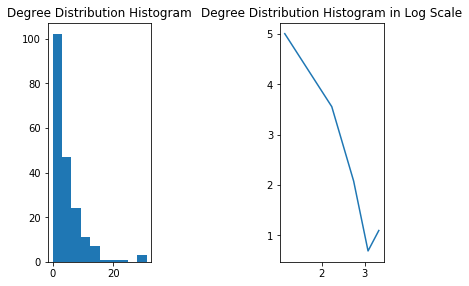

In [110]:
draw_degree_distribution(G)

<B>Observations:</B>
1. The degree distribution neither bionomial nor follows power law. Looks like the graph is random graph.
2. The total degree is mostly in the range of 1 to 9. Average degree is 4.32
3. The average in_degree and out_degree is same - around 2.16

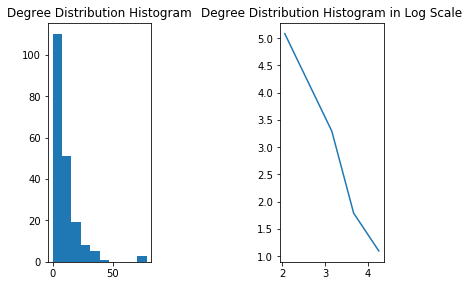

In [111]:
draw_degree_distribution(GNew)

<B>Observations: </B> 
1. The orignial graph (G) does not seem to follow degree distribution pattern of scale free graph. Especially on the log-log scale, it is not a straight line like in scale free graph.
2. However, the updated graph (GNew) where indirect dependencies are directly added to each node, the graph looks like scale free graph with power law degree distribution

### In and Out Degree
The In and Out Degree's and dependencies are better visualized in the new graph as shown below.

The graph below shows GNew graph. The nodes size depends on in-degree. This essentially means that nodes (packages) like "uniq" or "zope.publiser" have larger dependency on other packages.

<img src="GNew-Indegree.png" alt="New Graph - Node size based on In Degree" />

And the graph below shows the node sizes based on out-degree. This essentially means that packages like "setuptools", "six" and "zope.interface" are used by several other packages. 

<img src="GNew-OutDegree.png" alt="New Graph - Node size based on Out Degree" />

## Friendship Paradox

Does this network observe friendship paradox? If yes, how we can utilize it?

In [112]:
def avgNeighborDegree(node, graph):
    avg_degree = np.mean([graph.out_degree(node) for node in graph.neighbors(node)])
    return avg_degree

def computeFriendshipParadoxFraction(graph):
    friendship_paradox_holds = [1 if graph.out_degree(node) <  avgNeighborDegree(node, graph) else 0 for node in graph.nodes()]
    fraction_success = sum(friendship_paradox_holds)/len(friendship_paradox_holds)
    return fraction_success

fraction_success = computeFriendshipParadoxFraction(G)
print("The fraction of nodes for which friendship paradox holds true is ", fraction_success)

The fraction of nodes for which friendship paradox holds true is  0.2131979695431472


/Users/Avadhoot/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Avadhoot/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<B>Observation:</B> The friendship paradox does not hold true for this network.

In [113]:
fraction_success_new = computeFriendshipParadoxFraction(GNew)
print("The fraction of nodes for which friendship paradox holds true is ", fraction_success_new)

The fraction of nodes for which friendship paradox holds true is  0.8324873096446701


/Users/Avadhoot/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Avadhoot/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<B>Observation:</B> The friendship paradox holds true for this variation of network.

## Explore Centralities and Communities

In [114]:
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, "betweenness", betweenness)
closeness_centrality = nx.closeness_centrality(G)
nx.set_node_attributes(G, "closeness", closeness_centrality)
nx.write_gexf(G, graph_out_file_name)

The following visualization uses
1. Modularity as node color
2. Betweenness centrality as node size
This is original graph (G)

![title](G-Betweenness-Modularity.png)

<B>Observations:</B>
1. There are 10 identified communities (used resolution factor of 5). The bigger communities can be easily explained. For example, community around testing packages like pytest, community around notebook packages (notebook, nbconvert, ipykernel), communiy around django and community arond zope. 
2. This installation has bunch of completely separate packages like 1) pip and pipdeptree 2)flake and 3)networkx and decorator
3. The node size indicates betweenness centrality. It looks like pytest is the one which is used mostly across all communities. 

## Explore Change Propogation
A change in base module/package needs to be propogated to all the dependent modules. For example, a change in the package "uniq" would mean the package "uniq.utils" would also need to be changed. 

### Impact of Change
The the graph GNew can be used to understand the impact of the change. 

In [115]:
package_under_change = "uniq"
impacted_packages = nx.neighbors(GNew, package_under_change)
impacted_packages

['requests',
 'lxml',
 'pyyaml',
 'setuptools',
 'six',
 'more-itertools',
 'pytest',
 'attrs',
 'pluggy',
 'py',
 'urllib3',
 'python-dateutil',
 'artifactory',
 'pathlib',
 'deepdiff',
 'flaky',
 'ncclient',
 'paramiko',
 'netaddr',
 'pexpect',
 'pika',
 'psycopg2',
 'pytest-cov',
 'coverage',
 'pytest-mock',
 'pytest-xdist',
 'execnet',
 'pyvmomi',
 'requests-toolbelt',
 'selenium',
 'simplejson',
 'twine',
 'pkginfo',
 'uniq.apis',
 'uniq.apps',
 'uniq.clis',
 'uniq.utils',
 'maglev-cli',
 'uniq.gv-cli',
 'uniq.postgres',
 'uniq.testbed',
 'wheel']

### How many ways the change impacts me?

In [116]:
package_under_change = "jinja2"
my_package = "notebook"
paths = nx.all_simple_paths(G, package_under_change, my_package, cutoff=None)

for p in paths:
    print(p)

['jinja2', 'nbconvert', 'notebook']
['jinja2', 'notebook']


## Conclusion

1. In section 1, we saw that how a variation of the network can be created by directly linking the indirect dependencies
2. The 2 variations together can answer quite a few questions
3. The section 2 explains how the network is scale free (the second variation). 
4. The section 3 explains that the second variation of the network is Small World. This is useful to identify hubs (the packages with maximum depdendencies)
5. The community detection can be easily achieved using approach in section 4
6. In section 6, we explained how the impact of change can be measured and what are the change propogation mechanism